In [1]:
!pip install pytorch-lightning torch torchvision torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 48.1 MB/s eta 0:00:00


In [2]:
import zipfile

zip_file_path = "data.zip"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified path
    zip_ref.extractall()
    print(f"Files extracted")


Files extracted


In [3]:
import pytorch_lightning as pl
import torch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset


class ASLDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir: str = "data/raw",
        batch_size: int = 32,
        num_workers: int = 4,
        img_size: int = 224,
    ):
        super().__init__()
        self.save_hyperparameters()

        # --------------------
        # Transforms
        # --------------------
        self.train_transforms = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        self.val_transforms = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def setup(self, stage=None):
        # Load datasets with different transforms
        full_train = datasets.ImageFolder(
            root=self.hparams.data_dir,
            transform=self.train_transforms
        )

        full_val = datasets.ImageFolder(
            root=self.hparams.data_dir,
            transform=self.val_transforms
        )

        # Create deterministic split
        indices = torch.randperm(len(full_train))
        train_len = int(0.8 * len(indices))
        val_len = int(0.1 * len(indices))
        test_len = len(indices) - train_len - val_len

        self.train_set = Subset(
            full_train, indices[:train_len]
        )

        self.val_set = Subset(
            full_val, indices[train_len:train_len + val_len]
        )

        self.test_set = Subset(
            full_val, indices[train_len + val_len:]
        )

        # Needed by the model
        self.num_classes = len(full_train.classes)
        self.class_names = full_train.classes

    def train_dataloader(self):
        return DataLoader(
            self.train_set,
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=self.hparams.num_workers,
            pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_set,
            batch_size=self.hparams.batch_size,
            shuffle=False,
            num_workers=self.hparams.num_workers,
            pin_memory=True
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_set,
            batch_size=self.hparams.batch_size,
            shuffle=False,
            num_workers=self.hparams.num_workers,
            pin_memory=True
        )


In [7]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchmetrics
from torchvision.models import vit_b_16, ViT_B_16_Weights


class LitASLViT(pl.LightningModule):
    def __init__(
            self,
            num_classes: int,
            lr: float = 3e-4
    ):
        super().__init__()
        self.save_hyperparameters()

        self.model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        self.model.heads.head = nn.Linear(
            self.model.heads.head.in_features,
            num_classes
        )

        self.criterion = nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.train_acc(logits, y)

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.val_acc(logits, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.test_acc(logits, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=1e-4
        )


In [10]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


def main():
    datamodule = ASLDataModule(
        data_dir="data/raw",
        batch_size=32,
        img_size=224
    )
    datamodule.setup()

    model = LitASLViT(
        num_classes=datamodule.num_classes,
        lr=3e-4
    )

    checkpoint_cb = ModelCheckpoint(
        monitor="val_acc",
        mode="max",
        save_top_k=1,
        filename="asl-vit-{epoch:02d}-{val_acc:.2f}"
    )

    logger = TensorBoardLogger("logs", name="asl_vit")

    trainer = pl.Trainer(
        max_epochs=20,
        accelerator="auto",
        devices="auto",
        callbacks=[checkpoint_cb],
        logger=logger
    )

    trainer.fit(model, datamodule=datamodule)
    trainer.test(model, datamodule=datamodule, ckpt_path='best')



if __name__ == "__main__":
    main()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ VisionTransformer  │ 85.8 M │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss   │      0 │ train │     0 │
│ 2 │ train_acc │ MulticlassAccuracy │      0 │ train │     0 │
│ 3 │ val_acc   │ MulticlassAccuracy │      0 │ train │     0 │
│ 4 │ test_acc  │ MulticlassAccuracy │      0 │ train │     0 │
└───┴───────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 85.8 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 85.8 M                                                                                               
Total estimated model params size (MB): 343                                                                        
Modules in train mode: 156                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will 
create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller 
than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader 
running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/asl_vit/version_2/checkpoints/asl-vit-epoch=16-val_acc=0.96.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/asl_vit/version_2/checkpoints/asl-vit-epoch=16-val_acc=0.96.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9722222089767456     │
│         test_loss         │    0.10173281282186508    │
└───────────────────────────┴───────────────────────────┘

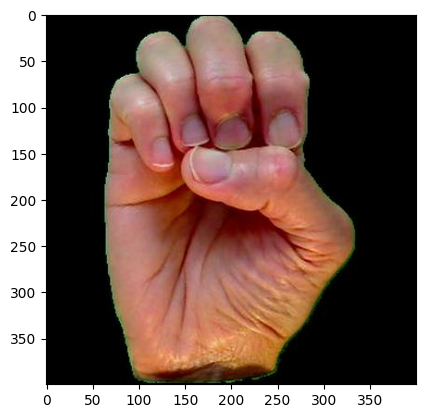

The predicted ASL gesture is: e


In [23]:
checkpoint_path = "logs/asl_vit/version_0/checkpoints/asl-vit-epoch=17-val_acc=0.97.ckpt"

model = LitASLViT.load_from_checkpoint(checkpoint_path)

image_path = "/content/data/raw/e/hand1_e_bot_seg_1_cropped.jpeg"

from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

def predict_custom_image(image_path, model):
    img = Image.open(image_path).convert('RGB')

    plt.imshow(img)
    plt.show()

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])


    input_tensor = preprocess(img).unsqueeze(0)


    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)


    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)
        index = torch.argmax(logits, dim=1).item()

    return index

resultat = predict_custom_image(image_path , model)

datamodule = ASLDataModule(
    data_dir="data/raw",
    batch_size=32,
    img_size=224
)
datamodule.setup()

predicted_index = resultat

if predicted_index < len(datamodule.class_names):
    predicted_gesture = datamodule.class_names[predicted_index]
    print(f"The predicted ASL gesture is: {predicted_gesture}")
else:
    print(f"Error: Class index {predicted_index} is out of bounds.")